# Load data

In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

# import torch

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae

sns.set(style="whitegrid")
#sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

import os
import sys
from pathlib import Path

PROJ_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJ_ROOT))  # add project root file to the python paths
data_path = PROJ_ROOT / "data"

from vol_predict.backtest.benchmark_backtester import BenchmarkBacktester
from vol_predict.models.baselines.benchmarks import Naive, EWMA, ARIMAX, GARCH, HAR, STS

In [97]:
full_data = (
    pl.read_csv(data_path / "btc" / "data_df.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
)

full_vola = full_data.select(["datetime",'vol']).with_columns(
    lagged_vola=pl.col("vol").shift(1)
).to_pandas().set_index("datetime").dropna()

In [98]:
LAST_TRAINING_DATE = datetime.strptime("2018-07-01 00:00:00", "%Y-%m-%d %H:%M:%S")
init_training_vola = full_vola.loc[:LAST_TRAINING_DATE]

# Reload

In [99]:
from vol_predict.backtest.benchmark_backtester import BenchmarkBacktester
from vol_predict.models.baselines.benchmarks import Naive, EWMA, ARIMAX, GARCH, HAR, STS

In [100]:
dataset = (
    pl.read_csv(data_path / "btc" / "data_df.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")#.with_columns(
        #lag_vol=pl.col("vol").shift(1)
    ).to_pandas().set_index("datetime").dropna()

# take all columns whos names starting with 'slope' and average them into one column
dataset["mean_spread"] = dataset.loc[:, dataset.columns.str.startswith("spread")].mean(axis=1)
dataset["mean_weighted_spread"] = dataset.loc[:, dataset.columns.str.startswith("weighted_spread")].mean(axis=1)
backtester = BenchmarkBacktester(
    dataset=dataset,
)

# Backtesting Univariate models

## Naive

In [101]:
backtest_results_naive = backtester.backtest(Naive)

100%|██████████| 1957/1957 [00:01<00:00, 1101.13it/s]

Backtest finished successfully.
---------------------------------------------------
Model: Naive
RMSE: 0.0002827
MAE:  0.0000921
Expanding training set: True
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


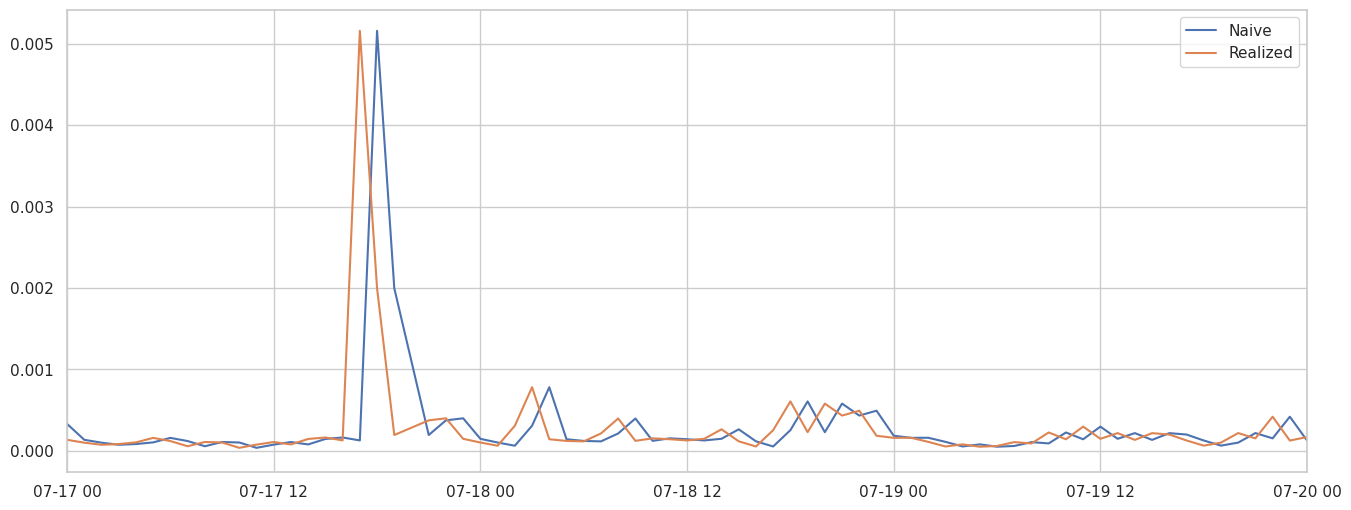

In [102]:
plt.plot(backtest_results_naive.forecasts, label="Naive")
plt.plot(backtest_results_naive.true_vola, label="Realized")
plt.xlim(
    datetime.strptime("2018-07-17 00:00:00", "%Y-%m-%d %H:%M:%S"),
    datetime.strptime("2018-07-20 00:00:00", "%Y-%m-%d %H:%M:%S"),
)
plt.legend()


## EWMA

In [103]:
backtest_results_ewma = backtester.backtest(EWMA, hyperparams={"look_back": 12, "half_life": 12})

100%|██████████| 1957/1957 [00:02<00:00, 913.90it/s] 

Backtest finished successfully.
---------------------------------------------------
Model: EWMA
RMSE: 0.0002475
MAE:  0.0000927
Expanding training set: True
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


## ARIMA

In [105]:
backtest_results_arima = backtester.backtest(ARIMAX, hyperparams={"p": 1, "d": 0, "q": 2}, is_multivariate=False)

  7%|▋         | 138/1957 [00:02<00:19, 95.63it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 23%|██▎       | 454/1957 [00:07<00:24, 60.72it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 45%|████▌     | 885/1957 [00:20<00:16, 63.53it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 54%|█████▎    | 1051/1957 [00:24<00:16, 56.15it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-pa

Backtest finished successfully.
---------------------------------------------------
Model: ARIMAX
RMSE: 0.0002341
MAE:  0.0000944
Expanding training set: True
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


## GARCH

In [106]:
backtest_results_garchx = backtester.backtest(GARCH, 
    hyperparams={"p": 1, "o": 0, "q": 1, 'dist': "normal"},
    is_multivariate=False)

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.688e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
  0%|          | 0/1957 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.683e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warning

Backtest finished successfully.
---------------------------------------------------
Model: GARCH
RMSE: 0.0002441
MAE:  0.0000832
Expanding training set: True
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


In [107]:
backtest_results_garchx = backtester.backtest(GARCH, 
    hyperparams={"p": 1, "o": 0, "q": 1, 'dist': "normal", 'type': "EGARCH"},
    is_multivariate=False)

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.688e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
  0%|          | 0/1957 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.683e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warning

Backtest finished successfully.
---------------------------------------------------
Model: GARCH
RMSE: 0.0320718
MAE:  0.0008941
Expanding training set: True
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


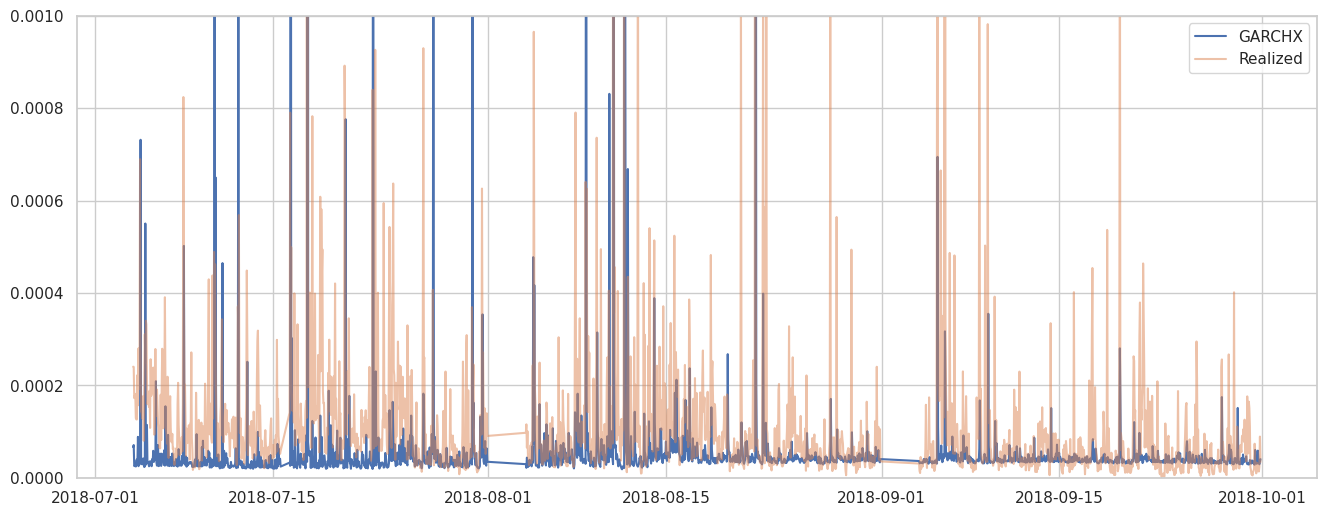

In [108]:
plt.plot(backtest_results_garchx.forecasts, label="GARCHX")
plt.plot(backtest_results_garchx.true_vola, label="Realized", alpha=0.5)
plt.ylim(0, 0.001)
plt.legend()

Using t-distribution (skewed or not) leads to convergence issues, even in the expanding window. 

## HAR

In [109]:
from arch.univariate.distribution import (
    Distribution,
    GeneralizedError,
    Normal,
    SkewStudent,
    StudentsT,
)


In [110]:
backtest_results_har = backtester.backtest(HAR, 
    hyperparams={'lags':[1, 6, 24], 'distribution': Normal()},
    is_multivariate=False)

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.204e-08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+04 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
  0%|          | 0/1957 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.199e-08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+04 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  war

Backtest finished successfully.
---------------------------------------------------
Model: HAR
RMSE: 0.0002307
MAE:  0.0000923
Expanding training set: True
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------
